In [15]:
from math import ceil
from sklearn.utils import shuffle
import pandas as pd
import numpy as np 
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import model_selection 
import seaborn as sns 
from sklearn.model_selection import StratifiedKFold 
from sklearn import metrics
from numpy import mean
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import 
import torch.nn.functional as nnf
from sklearn.tree import DecisionTreeClassifier
from fastai.tabular.all import *
import os

In [17]:

def getDataframe(p):
    print(f"file name : {os.path.split(p)[1]}")
    if os.path.split(p)[1] == 'JM1.csv':
        df = pd.read_csv(p)
        df['label'] = df['label'].map({"b'N'" :False,"b'Y'" :True})
        return df
    else:
        df = pd.read_csv(p)
        df['Defective'] = df['Defective'].map({"b'N'" :False,"b'Y'" :True})
        return df


# preprecessing 

def normalize(df):
    result = df.copy()
    for col in df.iloc[:,:-1].columns:
        max_value = df[col].max()
        min_value = df[col].min()
        result[col] = (df[col] - min_value) / (max_value - min_value)
    # print(df.head())
    return result

def preprocessing(df):
    # select k best columns
    best_features = SelectKBest(score_func=chi2,k=10)
    fit = best_features.fit(df.iloc[:,:-1],df.iloc[:,-1])

    dfscores = pd.DataFrame(fit.scores_)
    df_cols = pd.DataFrame(df.iloc[:,:-1].columns)

    feature_scores = pd.concat([df_cols,dfscores],axis=1)
    feature_scores.columns = ['parameters','score']
    selected_features = feature_scores.nlargest(10,'score').parameters.values
    df = df.drop(selected_features, axis=1)
    # normalize the data
    df = normalize(df)
    return df




# making bags
def sampling(df):
    # create 2 sets of majority and minority samples
    a = df[df.iloc[:,-1] == False]
    b = df[df.iloc[:,-1] == True]
    majority = None
    minority = None
    if a.shape[0] > b.shape[0]:
        # print("here")
        majority = a
        minority = b
    else:
        # print("there")
        minority = b
        majority = a
    # print(majority.head())
    # print(minority.head())

    # no of bags 
    bags = ceil(majority.shape[0]/minority.shape[0]) + 2
    print(f"majority cnt :{majority.shape[0]} , minority cnt :{minority.shape[0]} and number of bags: {bags}")
    subsets = []
    for i in range(bags):
        maj_sample = majority.sample(n=minority.shape[0])
        balanced_subset = pd.concat([minority,maj_sample])
        # print(maj_sample.shape)
        # print(balanced_subset.shape)
        balanced_subset = shuffle(balanced_subset)
        # print(balanced_subset.head())
        print(balanced_subset.shape)
        subsets.append(balanced_subset)

    return subsets

    
# train  
def trainModels(balanced_subsets):
    trained_models = []
    for subset in balanced_subsets:
        df = subset
        # cont_names = df.columns
        cat_names = []
        procs=[]
        df1 = subset
        cont_names = ['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
            'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY',
            'ESSENTIAL_COMPLEXITY', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
            'HALSTEAD_ERROR_EST', 'HALSTEAD_LEVEL', 'NUM_UNIQUE_OPERATORS',
            'Defective']
        cat_names = []
        procs=[]
        # config = tabular_config(embed_p=0.6, use_bn=False); config
        dls = TabularDataLoaders.from_df(df1,path='.',procs=None,cont_names=cont_names[:-1],cat_names=None,y_names=cont_names[-1])
        learn = tabular_learner(dls,[400,200,100,50],metrics=[accuracy,RocAucBinary()])
        learn.fit_one_cycle(10,1e-3)
        # learn.show_training_loop()
        trained_models.append(learn)
    return trained_models

def majorityVoteWieghtage(trained_models, testSet):
    # finalpreds = []
    fp = []
    probs = []
    for model in trained_models:
        dl_test = model.dls.test_dl(testSet, with_labels=True)
        preds = model.get_preds(dl=dl_test)
        # print(preds)
        fp.append(preds[1].T.squeeze())
        probs.append(preds[0].T.squeeze())
    # print(probs[0].shape)
    t1 = torch.stack(fp)
    t1 = t1.T
    p1 = torch.stack(probs)
    p1 = p1.T
    # print(t1.shape)
    # print(t1)
    # print(p1.shape)
    # print(p1)
    p1 = torch.mean(p1,dim=2)
    p1 = p1.squeeze()
    prob = nnf.softmax(p1, dim=1)
    top_p, top_class = prob.topk(1, dim = 1)

    return top_class.squeeze(),p1
        
        

In [18]:
df = getDataframe("Dataset/KC1.csv")


# splitting data into train and test sets
train,testSet = train_test_split(df,test_size=0.2)
# print(df.head())
print(train.head(),testSet.head())

# create balanced subset datasets having all minority sets and a random sample from majority set.
balanced_subsets = sampling(train)


# get all trained models from all the above balanced subsets
trained_models = trainModels(balanced_subsets)

minorityClassifierPreds,minorityClassifierProbs = majorityVoteWieghtage(trained_models,testSet)






file name : KC1.csv
      LOC_BLANK  BRANCH_COUNT  LOC_CODE_AND_COMMENT  LOC_COMMENTS  \
1951        0.0           1.0                   0.0           0.0   
1282        1.0          11.0                   0.0           8.0   
1559        0.0           1.0                   0.0           0.0   
192         0.0           1.0                   0.0           0.0   
796         0.0           1.0                   0.0           0.0   

      CYCLOMATIC_COMPLEXITY  DESIGN_COMPLEXITY  ESSENTIAL_COMPLEXITY  \
1951                    1.0                1.0                   1.0   
1282                    6.0                4.0                   1.0   
1559                    1.0                1.0                   1.0   
192                     1.0                1.0                   1.0   
796                     1.0                1.0                   1.0   

      LOC_EXECUTABLE  HALSTEAD_CONTENT  HALSTEAD_DIFFICULTY  ...  \
1951             0.0              4.75                 1.00  ...

In [20]:
def majTrain(train):
    cont_names = ['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
            'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY',
            'ESSENTIAL_COMPLEXITY', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
            'HALSTEAD_ERROR_EST', 'HALSTEAD_LEVEL', 'NUM_UNIQUE_OPERATORS',
            'label']
    cat_names = []
    procs=[]
    dls = TabularDataLoaders.from_df(train,path='.',procs=None,cont_names=cont_names[:-1],cat_names=None,y_names=cont_names[-1])
    learn = tabular_learner(dls,[400,200,100,50],metrics=[accuracy,RocAucBinary()])
    learn.fit_one_cycle(10,1e-3)
    return learn

def majPrediction(model,testSet):
    dl_test = model.dls.test_dl(testSet, with_labels=true)
    preds = model.get_preds(dl=dl_test)
    return preds
    

In [ ]:
# train majority for majority class

# maj_trained_model = trainModels([train])
majorityClassifier = majTrain(train)

In [21]:
preds = majPrediction(majorityClassifier,testSet)

In [22]:
def meta(mnPred,mnProbs,mjPreds,mjprobs,Wmn,Wmj):
    final_preds = torch.zeros_like(mnPred)
    for i in range(mnPred.shape[0]):
        if mjPreds[i] == 1:
            final_preds[i] = 1
        elif mnPred[i] == 0:
            final_preds[i] = 0
        else:
            z = (mnProbs[i]*Wmn + mjprobs[i]*Wmj)/2
            # print(z)
            if(z[0] > z[1]):
                final_preds[i] = 0
            else:
                final_preds[i] = 1
    return final_preds

In [23]:
predictions = meta(minorityClassifierPreds,minorityClassifierProbs,preds[1],preds[0],1.5,1)

In [24]:
from sklearn.metrics import roc_curve

# roc curve for modelsa
fpr1, tpr1, thresh1 = roc_curve(testSet.iloc[:,-1], preds[1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(testSet.iloc[:,-1], minorityClassifierPreds, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(testSet.iloc[:,-1], predictions, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(testSet.iloc[:,-1]))]
p_fpr, p_tpr, _ = roc_curve(testSet.iloc[:,-1], random_probs, pos_label=1)

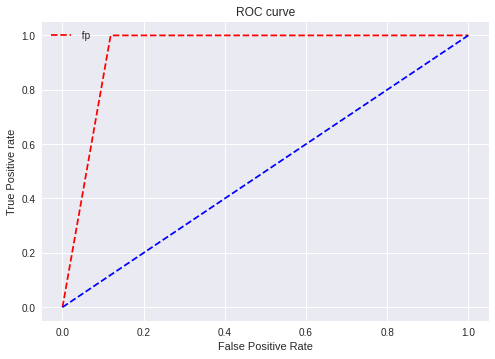

In [25]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Majority DNN')
# plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Minority DNN')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label=' fp')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [26]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(testSet.iloc[:,-1], predictions)
# auc_score2 = roc_auc_score(testSet.iloc[:,-1], )

print(auc_score1)

0.9406779661016949
